In [1]:
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
import csv
import re
import pickle
import time
from tqdm import tqdm
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
SEED = 1234

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

torch.backends.cudnn.deterministic = True

In [4]:
with open('../Dataset/RCV1-V2/rcv1_X_train.pickle', 'rb') as f:
    X_train = pickle.load(f)

with open('../Dataset/RCV1-V2/rcv1_y_train.pickle', 'rb') as f:
    y_train = pickle.load(f)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.05)

100%|██████████| 611354/611354 [00:54<00:00, 11266.08it/s]


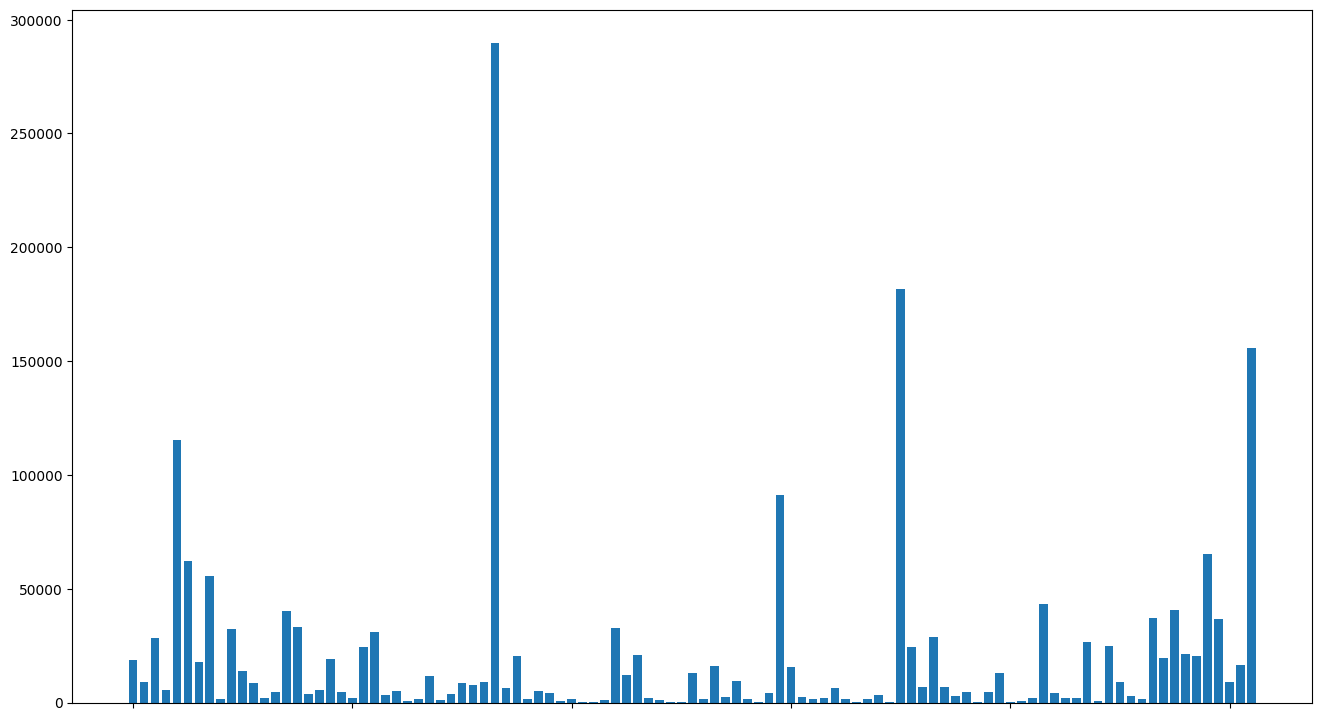

In [6]:
labels_count = [0] * 103

for label in tqdm(y_train):
    for i in range(len(label)):
        if label[i] == 1:
            labels_count[i] += 1

fig, ax = plt.subplots(figsize=(16, 9))
ax.bar(np.arange(103), labels_count)
ax.tick_params(axis='x', labelrotation=90)
ax.set_xticklabels([])
plt.show()

In [7]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)


print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(611354, 200) (611354, 103)
(32177, 200) (32177, 103)
(160883, 200) (160883, 103)


In [8]:
max_length = 200

In [9]:
# save word2idx, maxlength
with open('RCV1-V2_model/maxlength.pkl', 'wb') as f:
    pickle.dump(max_length, f)

In [10]:
class CustomDataset(Dataset):
    def __init__(self, sequence, labels):
        self.sequence = sequence
        self.labels = labels

    def __len__(self):
        return len(self.sequence)

    def __getitem__(self, idx):
        sequence_in = torch.tensor(self.sequence[idx]).float()
        output_label = torch.tensor(self.labels[idx]).float()
        return sequence_in, output_label

In [11]:
batch_size = 64

dataset_train = CustomDataset(X_train, y_train)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_val = CustomDataset(X_val, y_val)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

dataset_test = CustomDataset(X_test, y_test)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

In [12]:
class MLP_MLTC(nn.Module):
    def __init__(self, embedding_dim, num_classes, dropout=0.2):
        super(MLP_MLTC, self).__init__()

        self.fc1 = nn.Linear(embedding_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid()

    def forward(self, sentence):

        output = self.fc1(sentence)
        output = torch.relu(output)
        output = self.dropout1(output)

        output = self.fc2(output)
        output = torch.relu(output)
        output = self.dropout2(output)
        
        output = self.fc3(output)
        output = self.sigmoid(output)

        return output

In [13]:
num_classes = 103

# Hyperparameters
embedding_dim = 200
dropout = 0.2
epochs = 10
learning_rate = 0.001


model = MLP_MLTC(embedding_dim, num_classes, dropout)
loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [14]:
def train_model(model, loss_function, optimizer, epochs, device):

    train_loss, val_loss = [], []
    total_time = 0
    min_average_loss = float('inf')
    
    for epoch in range(epochs):
        start_time = time.time()

        print("Epoch : ", epoch + 1)

        model.to(device)
        model.train()
        total_train_loss = 0
        y_true_train, y_pred_train = [], []
        for batch in tqdm(dataloader_train, desc='Training'):
            sequence_in, output_label = batch
            sequence_in, output_label = sequence_in.to(device), output_label.to(device)

            model.zero_grad()
            pred_batch = model(sequence_in)
            loss = loss_function(pred_batch, output_label)
            total_train_loss += loss.item()

            y_true_train.extend(output_label.cpu().detach().numpy().tolist())
            y_pred_train.extend(pred_batch.cpu().detach().numpy().tolist())

            loss.backward()
            optimizer.step()
        

        model.eval()        
        total_val_loss = 0
        y_true_val, y_pred_val = [], []
        with torch.no_grad():
            for batch in tqdm(dataloader_val, desc='Evaluate'):
                sequence_in, output_label = batch
                sequence_in, output_label = sequence_in.to(device), output_label.to(device)

                pred_batch = model(sequence_in)
                loss = loss_function(pred_batch, output_label)
                total_val_loss += loss.item()

                y_true_val.extend(output_label.cpu().detach().numpy().tolist())
                y_pred_val.extend(pred_batch.cpu().detach().numpy().tolist())

        y_true_train = np.array(y_true_train)
        y_pred_train = np.array(y_pred_train)
        y_true_val = np.array(y_true_val)
        y_pred_val = np.array(y_pred_val)

        y_pred_train = y_pred_train >= 0.5
        y_pred_val = y_pred_val >= 0.5

        train_f1_score_micro = metrics.f1_score(y_true_train, y_pred_train, average='micro')
        val_f1_score_micro = metrics.f1_score(y_true_val, y_pred_val, average='micro')

        average_train_loss = float(total_train_loss / len(dataloader_train))
        average_val_loss = float(total_val_loss / len(dataloader_val))

        print('Train F1 Score (Micro)', train_f1_score_micro)
        print('Val F1 Score (Micro)', val_f1_score_micro)
        print('Train loss', average_train_loss)
        print('Val loss', average_val_loss)

        train_loss.append(average_train_loss)
        val_loss.append(average_val_loss)

        if average_val_loss < min_average_loss:
            min_average_loss = average_val_loss
            torch.save(model, 'RCV1-V2_model/model.pth')
            print("Best model saved")
            
        print("------------------------------------------------")

        end_time = time.time()
        epoch_time = end_time - start_time
        total_time += epoch_time

    avg_epoch_time = total_time / epochs
    return train_loss, val_loss, avg_epoch_time

In [15]:
train_loss, val_loss, avg_epoch_time = train_model(model, loss_function, optimizer, epochs, device)

Epoch :  1


Evaluate: 100%|██████████| 503/503 [00:02<00:00, 208.52it/s]


Train F1 Score (Micro) 0.711706103938423
Val F1 Score (Micro) 0.8137680813481644
Train loss 0.047990333165875546
Val loss 0.030168786200566983
Best model saved
------------------------------------------------
Epoch :  2


Evaluate: 100%|██████████| 503/503 [00:02<00:00, 212.85it/s]


Train F1 Score (Micro) 0.8070012763431613
Val F1 Score (Micro) 0.8323448064718673
Train loss 0.032236044814851685
Val loss 0.02740019929426802
Best model saved
------------------------------------------------
Epoch :  3


Evaluate: 100%|██████████| 503/503 [00:02<00:00, 183.33it/s]


Train F1 Score (Micro) 0.8176328723198457
Val F1 Score (Micro) 0.8385341522733831
Train loss 0.030625738278982854
Val loss 0.02644133876831406
Best model saved
------------------------------------------------
Epoch :  4


Evaluate: 100%|██████████| 503/503 [00:02<00:00, 204.26it/s]


Train F1 Score (Micro) 0.8224018579912588
Val F1 Score (Micro) 0.84049152516153
Train loss 0.029869343845531894
Val loss 0.025941791314683542
Best model saved
------------------------------------------------
Epoch :  5


Evaluate: 100%|██████████| 503/503 [00:02<00:00, 211.67it/s]


Train F1 Score (Micro) 0.8243759073341481
Val F1 Score (Micro) 0.8430399876882039
Train loss 0.02950721516765363
Val loss 0.02569242294648177
Best model saved
------------------------------------------------
Epoch :  6


Evaluate: 100%|██████████| 503/503 [00:39<00:00, 12.78it/s] 


Train F1 Score (Micro) 0.8261908321200777
Val F1 Score (Micro) 0.8438297894201476
Train loss 0.029246181053760992
Val loss 0.025529550181083365
Best model saved
------------------------------------------------
Epoch :  7


Evaluate: 100%|██████████| 503/503 [00:03<00:00, 155.70it/s]


Train F1 Score (Micro) 0.8272427227134908
Val F1 Score (Micro) 0.8447991787501604
Train loss 0.02906431544101823
Val loss 0.025360902984280353
Best model saved
------------------------------------------------
Epoch :  8


Evaluate: 100%|██████████| 503/503 [00:02<00:00, 225.85it/s]


Train F1 Score (Micro) 0.8281200338768213
Val F1 Score (Micro) 0.8445940044696755
Train loss 0.02891180188754139
Val loss 0.02526402560101589
Best model saved
------------------------------------------------
Epoch :  9


Evaluate: 100%|██████████| 503/503 [00:02<00:00, 216.49it/s]


Train F1 Score (Micro) 0.8287575006467647
Val F1 Score (Micro) 0.845763033369733
Train loss 0.028790830186275047
Val loss 0.025245329368837312
Best model saved
------------------------------------------------
Epoch :  10


Evaluate: 100%|██████████| 503/503 [00:02<00:00, 224.57it/s]


Train F1 Score (Micro) 0.8292609496547222
Val F1 Score (Micro) 0.8465004690647925
Train loss 0.02870226881077723
Val loss 0.025123247658282104
Best model saved
------------------------------------------------


# Evaluation

In [16]:
def test_scores(model, device):

    model.eval()

    y_true = []
    y_pred = []
    with torch.no_grad():
        for batch in tqdm(dataloader_test, desc='Evaluate'):
            sequence_in, output_label = batch
            sequence_in, output_label = sequence_in.to(device), output_label.to(device)

            pred_batch = model(sequence_in)
            pred_batch = (pred_batch > 0.5).float()

            y_true.extend(output_label.cpu().detach().numpy().tolist())
            y_pred.extend(pred_batch.cpu().detach().numpy().tolist())


    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    accuracy = metrics.accuracy_score(y_true, y_pred)
    f1_score_micro = metrics.f1_score(y_true, y_pred, average='micro')

    print('Test Accuracy', accuracy)
    print('Test F1 Score (Micro)', f1_score_micro)

    print('Classification report')
    print(classification_report(y_true, y_pred, zero_division=0))

In [17]:
model = torch.load('RCV1-V2_model/model.pth')
test_scores(model, device)

Evaluate: 100%|██████████| 2514/2514 [00:11<00:00, 213.36it/s]


Test Accuracy 0.5985840641957199
Test F1 Score (Micro) 0.8449079842683609
Classification report
              precision    recall  f1-score   support

           0       0.70      0.21      0.32      4838
           1       0.81      0.61      0.70      2460
           2       0.75      0.28      0.41      7672
           3       0.76      0.31      0.44      1573
           4       0.94      0.92      0.93     30397
           5       0.95      0.88      0.91     16497
           6       0.90      0.77      0.83      4692
           7       0.88      0.80      0.84     14532
           8       0.79      0.06      0.11       382
           9       0.87      0.73      0.79      8390
          10       0.85      0.66      0.74      3652
          11       0.89      0.75      0.81      2301
          12       0.75      0.54      0.63       519
          13       0.94      0.90      0.92      1154
          14       0.88      0.79      0.83     10604
          15       0.83      0.76      

In [18]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad) 

print(model)
print(f'The model has {num_params:,} trainable parameters')

MLP_MLTC(
  (fc1): Linear(in_features=200, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=103, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (sigmoid): Sigmoid()
)
The model has 40,679 trainable parameters


In [19]:
print('Train loss', train_loss)
print('Val loss', val_loss)

Train loss [0.047990333165875546, 0.032236044814851685, 0.030625738278982854, 0.029869343845531894, 0.02950721516765363, 0.029246181053760992, 0.02906431544101823, 0.02891180188754139, 0.028790830186275047, 0.02870226881077723]
Val loss [0.030168786200566983, 0.02740019929426802, 0.02644133876831406, 0.025941791314683542, 0.02569242294648177, 0.025529550181083365, 0.025360902984280353, 0.02526402560101589, 0.025245329368837312, 0.025123247658282104]


In [20]:
print('Avg epoch time', round(avg_epoch_time, 2), 'secs')

Avg epoch time 172.03 secs
